In [1]:
try:
    %load_ext autoreload
    %autoreload 2
except:
    pass

import argparse
from collections import OrderedDict
import datetime
import matplotlib.pylab as plt
from numbers import Number
import numpy as np
import gc
import pandas as pd
import pdb
import pickle
import pprint as pp
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import grad
from torch_geometric.data.dataloader import DataLoader
from chaotic_ellipse_dataset import Ellipse
from utils import compute_pressForce
from tqdm import tqdm
import matplotlib.backends.backend_pdf
import pprint as pp
from IPython.display import display, HTML
pd.options.display.max_rows = 1500
pd.options.display.max_columns = 200
pd.options.display.width = 1000
pd.set_option('max_colwidth', 400)

import sys, os

from nbody_dataset import NBodyDataset
from diffusion_1d import TemporalUnet1D, GaussianDiffusion1D
from utils import p, get_item_1d, eval_simu, simulation, to_np_array, make_dir, pdump, pload
from le_pde.pytorch_net.util import filter_filename, groupby_add_keys, get_unique_keys_df, filter_df

device = torch.device("cuda:0")

pygame 2.5.0 (SDL 2.28.0, Python 3.7.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
def plot_im(matrix, design_coef_list, consistency_coef_list, title):
    fig = plt.figure()
    # ax = plt.gca()
    pos = plt.imshow(matrix, cmap='Blues', interpolation='none')
    plt.xlabel("consistency_coef")
    plt.ylabel("design_coef")
    plt.xticks(np.arange(0, len(consistency_coef_list)), labels=consistency_coef_list)
    plt.yticks(np.arange(0, len(design_coef_list)), labels=design_coef_list)
    plt.title(title)
    fig.colorbar(pos, ax=ax)
    plt.show()


def get_eval_fn(pos_target, last_n_step, gamma=2):
    """pos: [B, steps, F], pos_target: [F]"""
    assert len(pos_target.shape) == 1
    def point_eval_objective(pos):
        n_bodies = pos.shape[-1] // 4
        loss = torch.stack([(((pos[...,-last_n_step:,jj*4:jj*4+2] - pos_target).abs() ** gamma).sum(-1) ** (1/gamma)).mean() for jj in range(n_bodies)]).mean()
        return loss.item()
    return point_eval_objective


def get_eval_fn_std(pos_target, last_n_step, gamma=2):
    """pos: [B, steps, F], pos_target: [F]"""
    assert len(pos_target.shape) == 1
    def point_eval_objective_std(pos):
        n_bodies = pos.shape[-1] // 4
        loss = torch.cat([(((pos[...,-last_n_step:,jj*4:jj*4+2] - pos_target).abs() ** gamma).sum(-1) ** (1/gamma)) for jj in range(n_bodies)], -1).mean(-1)
        loss_std = loss.std()
        return loss_std.item()
    return point_eval_objective_std

## Exp inv_design:

In [ ]:
"""
standard-recurrence-10 best range: 
2-body, nt_2, noise_mean: design_coef: [0.2,0.4], consistency_coef: [0.1, 0.2], value: 0.137-0.145, 
    best: design_coef=0.4, consistency_coef=0.2, 

4-body, nt_2, noise_sum much better than mean: noise_sum: design_coef: [0.1,0.4], consistency_coef: [0.1, 0.2], value: 0.2 
    best: design_coef=0.1




"""

In [ ]:
exp_id = "inv_design"
dirname = f"results/inverse_design_diffusion/{exp_id}/"

filename_list = sorted(filter_filename(dirname, include="record"))
df_dict_list = []
for filename in filename_list:
    df_dict = {}
    data_record = pload(dirname + filename)
    df_dict.update(data_record)
    for key in ["pred", "pred_simu", "exp_id", "date_time", "model_name"]:
        df_dict.pop(key)
    df_dict_list.append(df_dict)
df = pd.DataFrame(df_dict_list)
dff = groupby_add_keys(
    df,
    by=["compose_n_bodies", "n_composed", "design_guidance", "design_coef", "consistency_coef"],
    add_keys=[],
    other_keys=["design_obj_simu", "design_obj_simu_nonan"],
)
dff_dict = dff.to_dict()
print(len(df))

In [ ]:
df.sort_values(by = ["design_obj_simu"])

In [ ]:
dff

In [ ]:
design_guidance_list = [
    "standard-recurrence-10",
    "universal-forward-pure-recurrence-10",
    "universal-forward-pure-recurrence-20",
    "universal-forward-pure-recurrence-10",
]

for design_guidance in design_guidance_list:
    design_coef_list = [0.01,0.02,0.03,0.04,0.05]
    consistency_coef_list = [0.0,0.01,0.02,0.03,0.04,0.05]
    matrix = np.zeros((5,6))
    for i, design_coef in enumerate(design_coef_list):
        for j, consistency_coef in enumerate(consistency_coef_list):
            key = (2, 0, design_guidance, design_coef, consistency_coef)
            if key in dff_dict['design_obj_simu']:
                matrix[i, j] = dff_dict['design_obj_simu'][key]
            else:
                matrix[i, j] = np.NaN
    plot_im(matrix, design_coef_list=design_coef_list, consistency_coef_list=consistency_coef_list, title=design_guidance)

In [ ]:
design_guidance_list = [
    "standard-recurrence-10",
    # "universal-backward-pure-recurrence-10",
]

for design_guidance in design_guidance_list:
    design_coef_list = [0.01,0.02,0.03,0.04,0.05,0.075,0.1,0.15,0.2,0.4]
    consistency_coef_list = [0.0,0.01,0.02,0.03,0.04,0.05,0.075,0.1,0.15,0.2,0.4]
    matrix = np.zeros((len(design_coef_list),len(consistency_coef_list)))
    for i, design_coef in enumerate(design_coef_list):
        for j, consistency_coef in enumerate(consistency_coef_list):
            key = (2, 0, design_guidance, design_coef, consistency_coef)
            if key in dff_dict['design_obj_simu']:
                matrix[i, j] = dff_dict['design_obj_simu'][key]
            else:
                matrix[i, j] = np.NaN
    plot_im(matrix, design_coef_list=design_coef_list, consistency_coef_list=consistency_coef_list, title=design_guidance)

In [ ]:
design_guidance_list = [
    # "standard-recurrence-10",
    "universal-backward-pure-recurrence-10",
]

for design_guidance in design_guidance_list:
    design_coef_list = [0.01,0.02,0.03,0.04,0.05,0.075,0.1,0.15,0.2]
    consistency_coef_list = [0.0,0.01,0.02,0.03,0.04,0.05,0.075,0.1,0.15,0.2,0.4]
    matrix = np.zeros((len(design_coef_list),len(consistency_coef_list)))
    for i, design_coef in enumerate(design_coef_list):
        for j, consistency_coef in enumerate(consistency_coef_list):
            key = (2, 0, design_guidance, design_coef, consistency_coef)
            if key in dff_dict['design_obj_simu']:
                matrix[i, j] = dff_dict['design_obj_simu'][key]
            else:
                matrix[i, j] = np.NaN
    plot_im(matrix, design_coef_list=design_coef_list, consistency_coef_list=consistency_coef_list, title=design_guidance)

In [ ]:
design_guidance_list = [
    "universal-forward-pure-recurrence-10",
    "universal-forward-pure-recurrence-20",
    
]

for design_guidance in design_guidance_list:
    design_coef_list = [0.001,0.002,0.005,0.01,0.02,0.03,0.04,0.05]
    consistency_coef_list = [0.0,0.001,0.002,0.005,0.01,0.02,0.03,0.04,0.05]
    matrix = np.zeros((len(design_coef_list),len(consistency_coef_list)))
    for i, design_coef in enumerate(design_coef_list):
        for j, consistency_coef in enumerate(consistency_coef_list):
            key = (2, 0, design_guidance, design_coef, consistency_coef)
            if key in dff_dict['design_obj_simu']:
                matrix[i, j] = dff_dict['design_obj_simu'][key]
            else:
                matrix[i, j] = np.NaN
    plot_im(matrix, design_coef_list=design_coef_list, consistency_coef_list=consistency_coef_list, title=design_guidance)

In [ ]:
design_guidance_list = [
    "standard-recurrence-10",
    "universal-forward-pure-recurrence-10",
    "universal-forward-pure-recurrence-20",
    "universal-backward-pure-recurrence-10",
]

for design_guidance in design_guidance_list:
    for compose_n_bodies in [2,4]:
        for n_composed in [0,1,2]:
            design_coef_list = [0.01,0.02,0.03,0.04,0.05]
            consistency_coef_list = [0.0,0.01,0.02,0.03,0.04,0.05]
            matrix = np.zeros((5,6))
            
            for i, design_coef in enumerate(design_coef_list):
                for j, consistency_coef in enumerate(consistency_coef_list):
                    key = (compose_n_bodies, n_composed, design_guidance, design_coef, consistency_coef)
                    if key in dff_dict['design_obj_simu']:
                        matrix[i, j] = dff_dict['design_obj_simu'][key]
                    else:
                        matrix[i, j] = np.NaN
            # if compose_n_bodies == 4 and n_composed==0:
            #     pdb.set_trace()
            title = f"{compose_n_bodies}-body   comp-{n_composed}  {design_guidance}"
            print(title)
            plot_im(matrix,
                    design_coef_list=design_coef_list,
                    consistency_coef_list=consistency_coef_list,
                    title=title)

## Exp inv_design 9-23:

In [15]:
exp_id = "inv_design"
date_time = "09-23"
dirname = f"results/inverse_design_diffusion/{exp_id}_{date_time}/"

filename_list = sorted(filter_filename(dirname, include="record"))
df_dict_list = []
for filename in filename_list:
    df_dict = {}
    data_record = pload(dirname + filename)
    df_dict.update(data_record)
    for key in ["pred", "pred_simu", "exp_id", "date_time", "model_name"]:
        df_dict.pop(key)
    df_dict_list.append(df_dict)
df = pd.DataFrame(df_dict_list)
dff = groupby_add_keys(
    df,
    by=["compose_n_bodies", "n_composed", "design_guidance", "design_coef", "consistency_coef", "design_fn_mode"],
    add_keys=[],
    other_keys=["design_obj_simu", "RMSE", "MAE"],
)
dff_dict = dff.to_dict()
print(len(df))
dff.style.background_gradient(cmap=plt.cm.get_cmap("PiYG_r"))

24


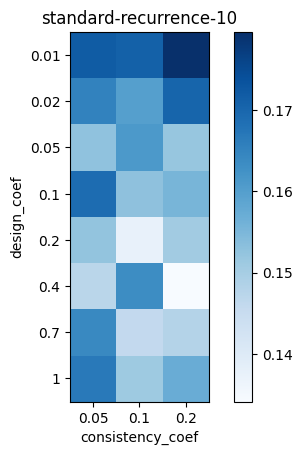

In [9]:
design_guidance_list = [
    "standard-recurrence-10",
]

for design_guidance in design_guidance_list:
    design_coef_list = [0.01,0.02,0.05,0.1,0.2,0.4,0.7,1]
    consistency_coef_list = [0.05,0.1,0.2]
    matrix = np.zeros((len(design_coef_list),len(consistency_coef_list)))
    for i, design_coef in enumerate(design_coef_list):
        for j, consistency_coef in enumerate(consistency_coef_list):
            key = (2, 0, design_guidance, design_coef, consistency_coef, "L2")
            if key in dff_dict['design_obj_simu']:
                matrix[i, j] = dff_dict['design_obj_simu'][key]
            else:
                print(2)
                matrix[i, j] = np.NaN
    plot_im(matrix, design_coef_list=design_coef_list, consistency_coef_list=consistency_coef_list, title=design_guidance)

## Exp L2square 9-23:

### body: 2, nt: 2

In [36]:
exp_id = "L2square"
date_time = "09-23"
dirname = f"results/inverse_design_diffusion/{exp_id}_{date_time}/"

filename_list = sorted(filter_filename(dirname, include="record"))
df_dict_list = []
for filename in filename_list:
    df_dict = {}
    data_record = pload(dirname + filename)
    df_dict.update(data_record)
    for key in ["pred", "pred_simu", "exp_id", "date_time", "model_name"]:
        df_dict.pop(key)
    df_dict_list.append(df_dict)
df = pd.DataFrame(df_dict_list)
dff = groupby_add_keys(
    df,
    by=["compose_n_bodies", "n_composed", "design_guidance", "design_coef", "design_fn_mode", "consistency_coef"],
    add_keys=[],
    other_keys=["design_obj_simu", "RMSE", "MAE"],
)
dff_dict = dff.to_dict()
print("Number of items: ", len(df))
dff.style.background_gradient(cmap=plt.cm.get_cmap("PiYG_r"))

Number of items:  16


In [6]:
def plot_im(matrix, design_coef_list, consistency_coef_list, title):
    fig = plt.figure()
    ax = plt.gca()
    pos = plt.imshow(matrix, cmap='Blues', interpolation='none')
    plt.xlabel("consistency_coef")
    plt.ylabel("design_coef")
    plt.xticks(np.arange(0, len(consistency_coef_list)), labels=consistency_coef_list)
    plt.yticks(np.arange(0, len(design_coef_list)), labels=design_coef_list)
    plt.title(title)
    fig.colorbar(pos, ax=ax)
    plt.show()

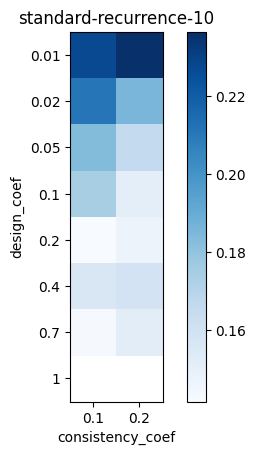

In [7]:
design_guidance_list = [
    "standard-recurrence-10",
]

for design_guidance in design_guidance_list:
    design_coef_list = [0.01,0.02,0.05,0.1,0.2,0.4,0.7,1]
    consistency_coef_list = [0.1,0.2]
    matrix = np.zeros((len(design_coef_list),len(consistency_coef_list)))
    for i, design_coef in enumerate(design_coef_list):
        for j, consistency_coef in enumerate(consistency_coef_list):
            key = (2, 0, design_guidance, design_coef, consistency_coef, "L2square")
            if key in dff_dict['design_obj_simu']:
                matrix[i, j] = dff_dict['design_obj_simu'][key]
            else:
                matrix[i, j] = np.NaN
    plot_im(matrix, design_coef_list=design_coef_list, consistency_coef_list=consistency_coef_list, title=design_guidance)

## Exp noise_sum 9-23:

### body: 2, nt: 2

In [42]:
exp_id = "noise_sum"
date_time = "09-23"
dirname = f"results/inverse_design_diffusion/{exp_id}_{date_time}/"

filename_list = sorted(filter_filename(dirname, include="record"))
df_dict_list = []
for filename in filename_list:
    df_dict = {}
    data_record = pload(dirname + filename)
    df_dict.update(data_record)
    for key in ["pred", "pred_simu", "exp_id", "date_time", "model_name"]:
        df_dict.pop(key)
    df_dict_list.append(df_dict)
df = pd.DataFrame(df_dict_list)
df2 = filter_df(df, filter_dict={
    "compose_n_bodies": 2,
    "n_composed": 0,
})
dff = groupby_add_keys(
    df2,
    by=["compose_n_bodies", "n_composed", "design_guidance", "design_coef", "consistency_coef", "compose_mode"],
    add_keys=[],
    other_keys=["design_obj_simu", "RMSE", "MAE"],
)
dff_dict = dff.to_dict()
print("Number of items: ", len(df))
dff.style.background_gradient(cmap=plt.cm.get_cmap("PiYG_r"))

Number of items:  54


### body: 2, nt: 4

In [43]:
exp_id = "noise_sum"
date_time = "09-23"
dirname = f"results/inverse_design_diffusion/{exp_id}_{date_time}/"

filename_list = sorted(filter_filename(dirname, include="record"))
df_dict_list = []
for filename in filename_list:
    df_dict = {}
    data_record = pload(dirname + filename)
    df_dict.update(data_record)
    for key in ["pred", "pred_simu", "exp_id", "date_time", "model_name"]:
        df_dict.pop(key)
    df_dict_list.append(df_dict)
df = pd.DataFrame(df_dict_list)
df2 = filter_df(df, filter_dict={
    "compose_n_bodies": 2,
    "n_composed": 2,
})
dff = groupby_add_keys(
    df2,
    by=["compose_n_bodies", "n_composed", "design_guidance", "design_coef", "consistency_coef", "compose_mode"],
    add_keys=[],
    other_keys=["design_obj_simu", "RMSE", "MAE"],
)
dff_dict = dff.to_dict()
print("Number of items: ", len(df))
dff.style.background_gradient(cmap=plt.cm.get_cmap("PiYG_r"))

Number of items:  54


### body: 4, nt: 2

In [40]:
exp_id = "noise_sum"
date_time = "09-23"
dirname = f"results/inverse_design_diffusion/{exp_id}_{date_time}/"

filename_list = sorted(filter_filename(dirname, include="record"))
df_dict_list = []
for filename in filename_list:
    df_dict = {}
    data_record = pload(dirname + filename)
    df_dict.update(data_record)
    for key in ["pred", "pred_simu", "exp_id", "date_time", "model_name"]:
        df_dict.pop(key)
    df_dict_list.append(df_dict)
df = pd.DataFrame(df_dict_list)
# df2 = df
df2 = filter_df(df, filter_dict={
    "compose_n_bodies": 4,
    "n_composed": 0,
})
dff = groupby_add_keys(
    df2,
    by=["compose_n_bodies", "n_composed", "design_guidance", "design_coef", "consistency_coef", "compose_mode"],
    add_keys=[],
    other_keys=["design_obj_simu", "RMSE", "MAE"],
)
dff_dict = dff.to_dict()
print("Number of items: ", len(df))
dff.style.background_gradient(cmap=plt.cm.get_cmap("PiYG_r"))

Number of items:  59


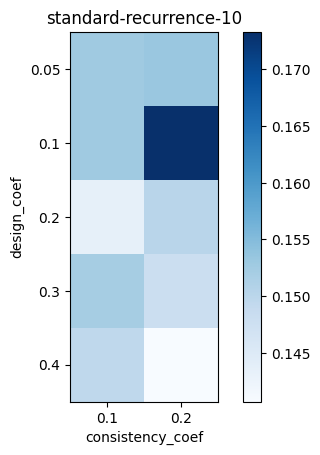

In [19]:
design_guidance_list = [
    "standard-recurrence-10",
]

for design_guidance in design_guidance_list:
    design_coef_list = [0.05,0.1,0.2,0.3,0.4]
    consistency_coef_list = [0.1,0.2]
    matrix = np.zeros((len(design_coef_list),len(consistency_coef_list)))
    for i, design_coef in enumerate(design_coef_list):
        for j, consistency_coef in enumerate(consistency_coef_list):
            key = (2, 0, design_guidance, design_coef, consistency_coef, "noise_sum")
            if key in dff_dict['design_obj_simu']:
                matrix[i, j] = dff_dict['design_obj_simu'][key]
            else:
                matrix[i, j] = np.NaN
    plot_im(matrix, design_coef_list=design_coef_list, consistency_coef_list=consistency_coef_list, title=design_guidance)

## New standard:

### Standard:

In [36]:
exp_id = "new-standard"
date_time = "09-24"
dirname = f"results/inverse_design_diffusion/{exp_id}_{date_time}/"

filename_list = sorted(filter_filename(dirname, include="record"))
df_dict_list = []
pos_target = torch.tensor([0.5, 0.5], dtype=float)
eval_fn = get_eval_fn(pos_target, last_n_step=1)
eval_fn_std = get_eval_fn_std(pos_target, last_n_step=1)
for filename in filename_list:
    df_dict = {}
    data_record = pload(dirname + filename)
    df_dict.update(data_record)
    pred = torch.tensor(df_dict["pred"])
    pred_simu = torch.tensor(df_dict["pred_simu"])
    design_obj_simu_CI = eval_fn_std(pred_simu) * 1.96 / np.sqrt(data_record["val_batch_size"])
    df_dict["design_obj_simu_CI"] = design_obj_simu_CI
    pred_simu = torch.cat([pred[:50,:1], pred_simu], 1)
    diff = pred - pred_simu
    RMSE = diff.square().mean((1,2)).sqrt().mean()
    RMSE_CI = diff.square().mean((1,2)).sqrt().std() * 1.96 / np.sqrt(data_record["val_batch_size"])
    MAE = torch.nn.L1Loss()(pred_simu, pred).item()
    MAE_CI = diff.abs().mean((1,2)).std().item() * 1.96 / np.sqrt(data_record["val_batch_size"])
    df_dict["RMSE"] = RMSE
    df_dict["RMSE_CI"] = RMSE_CI
    df_dict["MAE"] = MAE
    df_dict["MAE_CI"] = MAE_CI
    for key in ["pred", "pred_simu", "exp_id", "date_time", "model_name"]:
        df_dict.pop(key)
    df_dict_list.append(df_dict)
df2 = df = pd.DataFrame(df_dict_list)
# df2 = filter_df(df2, filter_dict={
#     "compose_n_bodies": 2,
#     "n_composed": 0,
# })
dff = groupby_add_keys(
    df2,
    by=["compose_n_bodies", "n_composed", "design_guidance", "design_coef", "consistency_coef", "compose_mode", "design_fn_mode"],
    add_keys=[],
    other_keys=["design_obj_simu", "design_obj_simu_CI", "MAE", "MAE_CI"],
)
dff_dict = dff.to_dict()
print("Number of items: ", len(df))
dff.style.background_gradient(cmap=plt.cm.get_cmap("PiYG_r"))

Number of items:  65


### Noise_sum:

In [7]:
exp_id = "new-standard-noise_sum"
date_time = "09-24"
dirname = f"results/inverse_design_diffusion/{exp_id}_{date_time}/"

filename_list = sorted(filter_filename(dirname, include="record"))
df_dict_list = []
for filename in filename_list:
    df_dict = {}
    data_record = pload(dirname + filename)
    df_dict.update(data_record)
    for key in ["pred", "pred_simu", "exp_id", "date_time", "model_name"]:
        df_dict.pop(key)
    df_dict_list.append(df_dict)
df = pd.DataFrame(df_dict_list)
# df2 = filter_df(df, filter_dict={
#     "compose_n_bodies": 2,
#     "n_composed": 0,
# })
dff = groupby_add_keys(
    df,
    by=["compose_n_bodies", "n_composed", "design_guidance", "design_coef", "consistency_coef", "compose_mode", "design_fn_mode"],
    add_keys=[],
    other_keys=["design_obj_simu", "RMSE", "MAE"],
)
dff_dict = dff.to_dict()
print("Number of items: ", len(df))
dff.style.background_gradient(cmap=plt.cm.get_cmap("PiYG_r"))

Number of items:  25


## compose_bodies

In [3]:
exp_id = "compose_bodies"
date_time = "09-25"
dirname = f"results/inverse_design_diffusion/{exp_id}_{date_time}/"

filename_list = sorted(filter_filename(dirname, include="record"))
df_dict_list = []
pos_target = torch.tensor([0.5, 0.5], dtype=float)
eval_fn = get_eval_fn(pos_target, last_n_step=1)
eval_fn_std = get_eval_fn_std(pos_target, last_n_step=1)
for filename in filename_list:
    df_dict = {}
    data_record = pload(dirname + filename)
    df_dict.update(data_record)
    pred = torch.tensor(df_dict["pred"])
    pred_simu = torch.tensor(df_dict["pred_simu"])
    design_obj_simu_CI = eval_fn_std(pred_simu) * 1.96 / np.sqrt(data_record["val_batch_size"])
    df_dict["design_obj_simu_CI"] = design_obj_simu_CI
    pred_simu = torch.cat([pred[:50,:1], pred_simu], 1)
    diff = pred - pred_simu
    RMSE = diff.square().mean((1,2)).sqrt().mean()
    RMSE_CI = diff.square().mean((1,2)).sqrt().std() * 1.96 / np.sqrt(data_record["val_batch_size"])
    MAE = torch.nn.L1Loss()(pred_simu, pred).item()
    MAE_CI = diff.abs().mean((1,2)).std().item() * 1.96 / np.sqrt(data_record["val_batch_size"])
    df_dict["RMSE"] = RMSE
    df_dict["RMSE_CI"] = RMSE_CI
    df_dict["MAE"] = MAE
    df_dict["MAE_CI"] = MAE_CI
    for key in ["pred", "pred_simu", "exp_id", "date_time", "model_name"]:
        df_dict.pop(key)
    df_dict_list.append(df_dict)
df2 = df = pd.DataFrame(df_dict_list)
# df2 = filter_df(df2, filter_dict={
#     "compose_n_bodies": 2,
#     "n_composed": 0,
# })
dff = groupby_add_keys(
    df2,
    by=["compose_n_bodies", "n_composed", "design_guidance", "design_coef", "consistency_coef", "compose_mode", "design_fn_mode"],
    add_keys=[],
    other_keys=["design_obj_simu", "design_obj_simu_CI", "MAE", "MAE_CI"],
)
dff_dict = dff.to_dict()
print("Number of items: ", len(df))
dff.style.background_gradient(cmap=plt.cm.get_cmap("PiYG_r"))

Number of items:  47


## paper-cluster

In [3]:
exp_id = "paper-cluster"
date_time = "09-27"
dirname = f"results/inverse_design_diffusion/{exp_id}_{date_time}/"

filename_list = sorted(filter_filename(dirname, include="record"))
df_dict_list = []
pos_target = torch.tensor([0.5, 0.5], dtype=float)
eval_fn = get_eval_fn(pos_target, last_n_step=1)
eval_fn_std = get_eval_fn_std(pos_target, last_n_step=1)
for filename in filename_list:
    df_dict = {}
    data_record = pload(dirname + filename)
    df_dict.update(data_record)
    pred = torch.tensor(df_dict["pred"])
    pred_simu = torch.tensor(df_dict["pred_simu"])
    design_obj_simu_CI = eval_fn_std(pred_simu) * 1.96 / np.sqrt(data_record["val_batch_size"])
    df_dict["design_obj_simu_CI"] = design_obj_simu_CI
    pred_simu = torch.cat([pred[:50,:1], pred_simu], 1)
    diff = pred - pred_simu
    RMSE = diff.square().mean((1,2)).sqrt().mean()
    RMSE_CI = diff.square().mean((1,2)).sqrt().std() * 1.96 / np.sqrt(data_record["val_batch_size"])
    MAE = torch.nn.L1Loss()(pred_simu, pred).item()
    MAE_CI = diff.abs().mean((1,2)).std().item() * 1.96 / np.sqrt(data_record["val_batch_size"])
    df_dict["RMSE"] = RMSE
    df_dict["RMSE_CI"] = RMSE_CI
    df_dict["MAE"] = MAE
    df_dict["MAE_CI"] = MAE_CI
    for key in ["pred", "pred_simu", "exp_id", "date_time", "model_name"]:
        df_dict.pop(key)
    df_dict_list.append(df_dict)
df2 = df = pd.DataFrame(df_dict_list)
# df2 = filter_df(df2, filter_dict={
#     "compose_n_bodies": 2,
#     "n_composed": 0,
# })
dff = groupby_add_keys(
    df2,
    by=["compose_n_bodies", "n_composed", "design_guidance", "design_coef", "consistency_coef", "compose_mode", "design_fn_mode"],
    add_keys=[],
    other_keys=["design_obj_simu", "design_obj_simu_CI", "MAE", "MAE_CI"],
)
dff_dict = dff.to_dict()
print("Number of items: ", len(df))
dff.style.background_gradient(cmap=plt.cm.get_cmap("PiYG_r"))

Number of items:  53


## Draw figures:

In [71]:
import matplotlib.pyplot as plt
import numpy as np
from utils import COLOR_LIST
markers = ['o', 's', '^', 'D', 'v', 'p', 'H', 'X']
def draw_multi_bodies(
    pred_design,
    pred=None,
    pred_simu=None,
    cond=None,
    cond_design=None,
    fontsize=12,
    labelsize=12,
    size=40,
    time_interval=4,
    id=None,
):
    '''
    cond : initial condition ,[batch_size,n_steps,n_bodies*features]
    pred : initial pred without design ,[batch_size,n_steps,n_bodies*features]
    cond_design : designed condition ,[batch_size,n_steps,n_bodies*features]
    pred_design : pred of designed condition ,[batch_size,n_steps,n_bodies*features]
    pred_simu :pred of simulation solver on designed condition, initial condition ,[batch_size,n_steps,n_bodies*features]
    time_interval: default 4,must be Multiples of 4

    '''
    
    time_interval = int(time_interval/4)
    pred_design = pred_design.reshape(pred_design.shape[0], pred_design.shape[1], -1, 4) #[batch_size,n_steps,n_bodies,n_features]
    batch_size = pred_design.shape[0]
    n_steps = pred_design.shape[1]
    n_bodies = pred_design.shape[2]
    alphas = np.linspace(0.1, 1.0, n_steps)
    if not(cond is None):
        cond = cond.reshape(cond.shape[0],cond.shape[1],-1,4)
    if not(cond_design is None):
        cond_design = cond_design.reshape(cond_design.shape[0], cond_design.shape[1], -1, 4)
    if not(pred is None):
        pred = pred.reshape(pred.shape[0], pred.shape[1], -1, 4)
    if not(pred_simu is None):
        pred_simu = pred_simu.reshape(pred_simu.shape[0], pred_simu.shape[1], -1, 4)
    for j in range(batch_size):
        if id is not None:
            if j != id:
                continue
        print(j)
        fig, ax = plt.subplots()
        for i in range(n_bodies):
            x = pred_design[j,::time_interval,i,0]
            y = pred_design[j,::time_interval,i,1]   
            ax.scatter(x, y, color=COLOR_LIST[i], alpha=alphas, marker='o', s=size)
            if not(cond is None):
                ax.scatter(cond[j,::time_interval,i,0],cond[j,::time_interval,i,1] ,color=COLOR_LIST[i],marker='+',s=size)
            if not(cond_design is None):
                ax.scatter(cond_design[j,::time_interval,i,0],cond_design[j,::time_interval,i,1] ,color=COLOR_LIST[i],marker='*',s=size)
            if not(pred is None):
                x = pred[j,::time_interval,i,0]
                y = pred[j,::time_interval,i,1]   
                ax.scatter(x, y, color=COLOR_LIST[i], alpha=alphas, marker='.', s=size)
            if not(pred_simu is None):
                x = pred_simu[j,::time_interval,i,0]
                y = pred_simu[j,::time_interval,i,1]   
                ax.scatter(x, y, color=COLOR_LIST[i], alpha=alphas, marker='^', s=size)

        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.tick_params(labelsize=labelsize)
        # plt.axis('off')
        plt.show()

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from utils import COLOR_LIST
markers = ['o', 's', '^', 'D', 'v', 'p', 'H', 'X']
def draw_multi_bodies(
    pred_design,
    pred=None,
    pred_simu=None,
    cond=None,
    cond_design=None,
    fontsize=12,
    labelsize=12,
    size=4000,
    time_interval=4,
    fig_name=None,
    id=None,
):
    '''
    cond : initial condition ,[batch_size,n_steps,n_bodies*features]
    pred : initial pred without design ,[batch_size,n_steps,n_bodies*features]
    cond_design : designed condition ,[batch_size,n_steps,n_bodies*features]
    pred_design : pred of designed condition ,[batch_size,n_steps,n_bodies*features]
    pred_simu :pred of simulation solver on designed condition, initial condition ,[batch_size,n_steps,n_bodies*features]
    time_interval: default 4,must be Multiples of 4

    '''
    
    time_interval = int(time_interval/4)
    pred_design = pred_design.reshape(pred_design.shape[0], pred_design.shape[1], -1, 4) #[batch_size,n_steps,n_bodies,n_features]
    batch_size = pred_design.shape[0]
    n_steps = pred_design.shape[1]
    n_bodies = pred_design.shape[2]
    alphas = np.linspace(0.15, 1, n_steps) ** 2
    if not(cond is None):
        cond = cond.reshape(cond.shape[0],cond.shape[1],-1,4)
    if not(cond_design is None):
        cond_design = cond_design.reshape(cond_design.shape[0], cond_design.shape[1], -1, 4)
    if not(pred is None):
        pred = pred.reshape(pred.shape[0], pred.shape[1], -1, 4)
    if not(pred_simu is None):
        pred_simu = pred_simu.reshape(pred_simu.shape[0], pred_simu.shape[1], -1, 4)
    for j in range(batch_size):
        if id is not None:
            if j != id:
                continue
        print(j)
        fig = plt.figure(figsize=(5.5,5))
        ax = plt.gca()
        for i in range(n_bodies):
            
            x = pred_design[j,::time_interval,i,0]
            y = pred_design[j,::time_interval,i,1]   
            ax.scatter(x, y, color=COLOR_LIST[i], alpha=alphas, marker='o', s=size)
            if not(pred_simu is None):
                x = pred_simu[j,::time_interval,i,0]
                y = pred_simu[j,::time_interval,i,1]   
                ax.scatter(x, y, color=COLOR_LIST[i], marker='+', s=100)
            
            
            
            if not(cond is None):
                ax.scatter(cond[j,::time_interval,i,0],cond[j,::time_interval,i,1] ,color=COLOR_LIST[i],marker='+',s=size)
            if not(cond_design is None):
                ax.scatter(cond_design[j,::time_interval,i,0],cond_design[j,::time_interval,i,1] ,color=COLOR_LIST[i],marker='*',s=size)
            if not(pred is None):
                x = pred[j,::time_interval,i,0]
                y = pred[j,::time_interval,i,1]   
                ax.scatter(x, y, color=COLOR_LIST[i], alpha=alphas, marker='.', s=size)
            plt.xlabel("x", fontsize=fontsize)
            plt.ylabel("y", fontsize=fontsize)
            

        ax.scatter([0.5], [0.5], color="k", marker="*", s=150)
        plt.xlim([0,1])
        plt.ylim([0,1])
        ax.set_axis_off()
        plt.tick_params(labelsize=labelsize)
        if fig_name is not None:
            fig = plt.gcf()
            # fig.set_size_inches(5, 5)
            plt.savefig(fig_name + f"-id_{id}.pdf", bbox_inches="tight")
        plt.show()

46


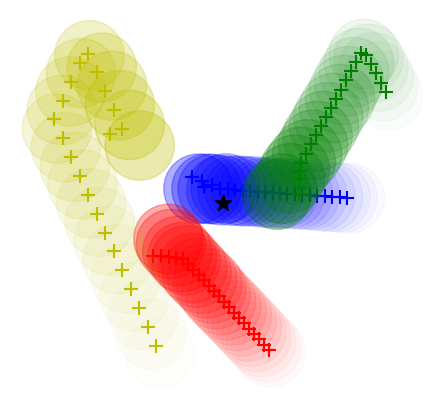

In [7]:
dirname = f"results/inverse_design_diffusion/paper/"
# 2-body 44 steps:
filename = "record_comp_2_nt_2_guid_standard-recurrence-10_descoef_0.4_conscoef_0.2_desmode_L2_compmode_mean-inside_val_50.p"
# 2-body 54 steps:
filename = "record_comp_2_nt_3_guid_standard-recurrence-10_descoef_0.4_conscoef_0.2_desmode_L2_compmode_mean-inside_val_50.p"


# # 4-body 44 steps
filename = "record_comp_4_nt_2_guid_standard-recurrence-10_descoef_0.4_conscoef_0.2_desmode_L2_compmode_mean-inside_val_50.p"

# 4, 46
data_record = pload(dirname + filename)
pred = data_record["pred"]
pred_simu = data_record["pred_simu"]
draw_multi_bodies(
    pred_design=pred,
    pred=None,
    pred_simu=pred_simu,
    cond=None,
    cond_design=None,
    fontsize=18,
    labelsize=18,
    size=2500,
    time_interval=8,
    fig_name="results/inverse_design_diffusion/paper/4-body-example",
    id=46,
)

24


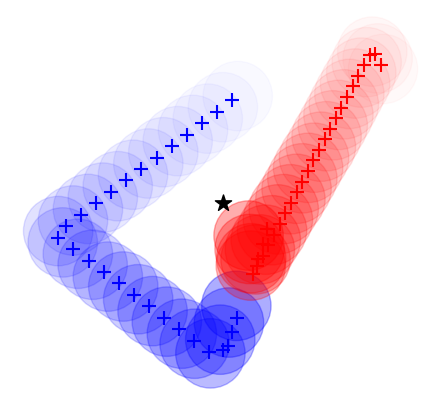

In [8]:
dirname = f"results/inverse_design_diffusion/paper/"
# 2-body 44 steps:
filename = "record_comp_2_nt_2_guid_standard-recurrence-10_descoef_0.4_conscoef_0.2_desmode_L2_compmode_mean-inside_val_50.p"
# 2-body 54 steps:
filename = "record_comp_2_nt_3_guid_standard-recurrence-10_descoef_0.4_conscoef_0.2_desmode_L2_compmode_mean-inside_val_50.p"
# 11,24,47

# # # 4-body 44 steps
# filename = "record_comp_4_nt_2_guid_standard-recurrence-10_descoef_0.4_conscoef_0.2_desmode_L2_compmode_mean-inside_val_50.p"
# # 4

data_record = pload(dirname + filename)
pred = data_record["pred"]
pred_simu = data_record["pred_simu"]
draw_multi_bodies(
    pred_design=pred,
    pred=None,
    pred_simu=pred_simu,
    cond=None,
    cond_design=None,
    fontsize=18,
    labelsize=18,
    size=2500,
    time_interval=8,
    fig_name="results/inverse_design_diffusion/paper/2-body-example.pdf",
    id=24,
)

24


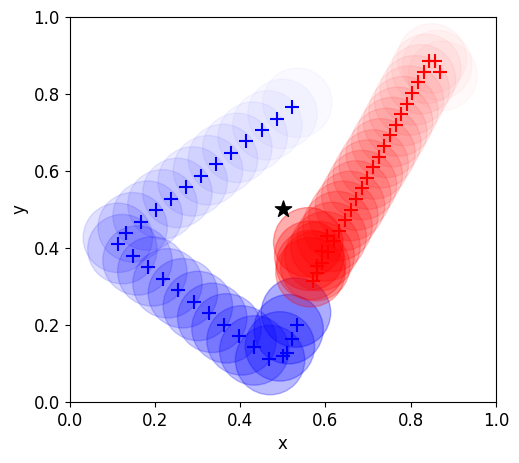

In [162]:
dirname = f"results/inverse_design_diffusion/paper/"
# 2-body 44 steps:
filename = "record_comp_2_nt_2_guid_standard-recurrence-10_descoef_0.4_conscoef_0.2_desmode_L2_compmode_mean-inside_val_50.p"
# 2-body 54 steps:
filename = "record_comp_2_nt_3_guid_standard-recurrence-10_descoef_0.4_conscoef_0.2_desmode_L2_compmode_mean-inside_val_50.p"
# 11,24

# # # 4-body 44 steps
# filename = "record_comp_4_nt_2_guid_standard-recurrence-10_descoef_0.4_conscoef_0.2_desmode_L2_compmode_mean-inside_val_50.p"
# # 4

data_record = pload(dirname + filename)
pred = data_record["pred"]
pred_simu = data_record["pred_simu"]
draw_multi_bodies(
    pred_design=pred,
    pred=None,
    pred_simu=pred_simu,
    cond=None,
    cond_design=None,
    fontsize=12,
    labelsize=12,
    size=2500,
    time_interval=8,
    fig_name="results/inverse_design_diffusion/paper/2-body-example.pdf",
    id=24,
)

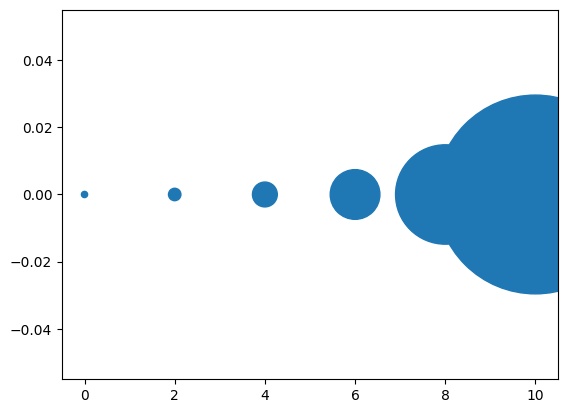

In [22]:
x = [0,2,4,6,8,10]
y = [0]*len(x)
s = [20*4**n for n in range(len(x))]
plt.scatter(x,y,s=s)
plt.show()